In [42]:
import pandas as pd
import statsmodels.api as sm
import numpy as np

file_path = "clean_all.csv"
data = pd.read_csv(file_path)

# Define education level mapping for the control variable
education_mapping = {
    'Less than high school diploma or its equivalent': 1,
    'High school diploma or a high school equivalency certificate': 2,
    'Trade certificate or diploma': 3,
    'College, CEGEP or other non-university certificate or diploma (other than trades certificates or diplomas)': 4,
    'University certificate or diploma below the bachelor\'s level': 5,
    'Bachelor\'s degree (e.g. B.A., B.Sc., LL.B.)': 6,
    'University certificate, diploma, degree above the bachelor\'s level': 7
}
data['educ_level'] = data['educ'].map(education_mapping)

# Calculate Debt-to-Income Ratio (DIR)
data['DIR'] = data['debt_impute'] / data['income_impute']
data['DIR'] = data['DIR'].replace([np.inf, -np.inf], np.nan)  
data['log_DIR'] = np.log(data['DIR'].replace(0, np.nan))  
data.dropna(subset=['DIR', 'log_DIR', 'income_impute'], inplace=True)

answer_keywords = {
    'scn1': ["Repay debt", "RRSP", "TFSA", "UL"]
}

question_pairs = {
    'scn1': ['scn1a_answer', 'scn1b_answer']
}
question = 'scn1'
options = answer_keywords[question]


data[question + '_combined'] = data[question_pairs[question][0]].fillna('') + ' ' + data[question_pairs[question][1]].fillna('')


conditions = [data[question + '_combined'].str.contains(opt, case=False, na=False) for opt in options]
data[question + '_target'] = np.select(conditions, options, default=np.nan)


data.dropna(subset=[question + '_target'], inplace=True)

data[question + '_target_code'] = data[question + '_target'].astype('category').cat.codes
mappings = {question + '_target': dict(enumerate(data[question + '_target'].astype('category').cat.categories))}

def percentage_to_float(x):
    if isinstance(x, str):
        return float(x.strip('%')) / 100
    return np.nan

data['scn1a_apr_float'] = data['scn1a_apr'].apply(percentage_to_float)
data['scn1b_apr_float'] = data['scn1b_apr'].apply(percentage_to_float)

data['scn1a_mtr_float'] = data['scn1a_mtr'].apply(percentage_to_float)
data['scn1b_mtr_float'] = data['scn1b_mtr'].apply(percentage_to_float)

data[['scn1a_apr_float', 'scn1b_apr_float', 'scn1a_mtr_float', 'scn1b_mtr_float']] = data[['scn1a_apr_float', 'scn1b_apr_float', 'scn1a_mtr_float', 'scn1b_mtr_float']].fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)

data['apr'] = data[['scn1a_apr_float', 'scn1b_apr_float']].mean(axis=1)
data['mtr'] = data[['scn1a_mtr_float', 'scn1b_mtr_float']].mean(axis=1)


X = data[['debt', 'age', 'educ_level', 'work_experience', 'income_impute', 'log_DIR', 'apr', 'mtr']]
X = sm.add_constant(X)


X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.dropna(inplace=True)
y = data[question + '_target_code'].loc[X.index]


model = sm.MNLogit(y, X)
result = model.fit()

print(f"\nMNLogit Results for {question}")
print(result.summary())

print(f"\nInterpretation for {question} options:")
for code, product in mappings[question + '_target'].items():
    print(f"Code {code}: {product}")


Optimization terminated successfully.
         Current function value: 0.769135
         Iterations 11

MNLogit Results for scn1
                          MNLogit Regression Results                          
Dep. Variable:       scn1_target_code   No. Observations:                  603
Model:                        MNLogit   Df Residuals:                      579
Method:                           MLE   Df Model:                           21
Date:                 周五, 15 11月 2024   Pseudo R-squ.:                 0.05441
Time:                        19:25:47   Log-Likelihood:                -463.79
converged:                       True   LL-Null:                       -490.47
Covariance Type:            nonrobust   LLR p-value:                 0.0001218
scn1_target_code=1       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
debt               -4.963e-08   3.67e-07     -0.135      0.892   

C:\Users\波尔多\AppData\Local\Temp\ipykernel_13704\1380739592.py:60: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[['scn1a_apr_float', 'scn1b_apr_float', 'scn1a_mtr_float', 'scn1b_mtr_float']] = data[['scn1a_apr_float', 'scn1b_apr_float', 'scn1a_mtr_float', 'scn1b_mtr_float']].fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
C:\Users\波尔多\AppData\Local\Temp\ipykernel_13704\1380739592.py:60: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[['scn1a_apr_float', 'scn1b_apr_float', 'scn1a_mtr_float', 'scn1b_mtr_float']] = data[['scn1a_apr_float', 'scn1b_apr_float', 'scn1a_mtr_float', 'scn1b_mtr_float']].fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)


In [ ]:
import pandas as pd
import statsmodels.api as sm
import numpy as np

file_path = "clean_all.csv"
data = pd.read_csv(file_path)
education_mapping = {
    'Less than high school diploma or its equivalent': 1,
    'High school diploma or a high school equivalency certificate': 2,
    'Trade certificate or diploma': 3,
    'College, CEGEP or other non-university certificate or diploma (other than trades certificates or diplomas)': 4,
    'University certificate or diploma below the bachelor\'s level': 5,
    'Bachelor\'s degree (e.g. B.A., B.Sc., LL.B.)': 6,
    'University certificate, diploma, degree above the bachelor\'s level': 7
}
data['educ_level'] = data['educ'].map(education_mapping)

# Calculate Debt-to-Income Ratio (DIR)
data['DIR'] = data['debt_impute'] / data['income_impute']
data['DIR'] = data['DIR'].replace([np.inf, -np.inf], np.nan)  # Handle inf values

data['log_DIR'] = np.log(data['DIR'].replace(0, np.nan))  # Replace 0 with NaN to avoid log(0)

data.dropna(subset=['DIR', 'log_DIR', 'income_impute'], inplace=True)

# Define keyword mappings for each question's options
answer_keywords = {
    'scn1': ["Repay debt", "RRSP", "TFSA", "UL"],
    'scn2': ["Diversified MF", "Partial annuity", "Seg funds", "All annuity"],
    'scn3': ["LTCI", "Invest in funds", "Payoff mortgage"],
    'scn4': ["GIC", "ETF", "Mutual Fund", "Seg. Funds"]
}

# Combine answers for each question (e.g., scn1a and scn1b)
question_pairs = {
    'scn1': ['scn1a_answer', 'scn1b_answer'],
    'scn2': ['scn2a_answer', 'scn2b_answer'],
    'scn3': ['scn3a_answer', 'scn3b_answer'],
    'scn4': ['scn4a_answer', 'scn4b_answer']
}

# Create a target variable for each question based on keywords
for question, options in answer_keywords.items():
    # Combine the answers in scnXa and scnXb into one column for keyword matching
    data[question + '_combined'] = data[question_pairs[question][0]].fillna('') + ' ' + data[question_pairs[question][1]].fillna('')
    
    conditions = [data[question + '_combined'].str.contains(opt, case=False, na=False) for opt in options]
    data[question + '_target'] = np.select(conditions, options, default=np.nan)


data.dropna(subset=['scn1_target', 'scn2_target', 'scn3_target', 'scn4_target'], inplace=True)

mappings = {}
for question in ['scn1_target', 'scn2_target', 'scn3_target', 'scn4_target']:
    data[question + '_code'] = data[question].astype('category').cat.codes
    mappings[question] = dict(enumerate(data[question].astype('category').cat.categories))

# Define independent variables, including income_impute and log_DIR
X = data[['debt', 'age', 'educ_level', 'work_experience', 'income_impute', 'log_DIR']]
X = sm.add_constant(X)  # Add intercept

X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.dropna(inplace=True)

for question_code in ['scn1_target_code', 'scn2_target_code', 'scn3_target_code', 'scn4_target_code']:
    y = data[question_code].loc[X.index] 

    # Fit the MNLogit model
    model = sm.MNLogit(y, X)
    result = model.fit()
    
    # Print summary for each question
    print(f"\nMNLogit Results for {question_code}")
    print(result.summary())
    
    print(f"\nInterpretation for {question_code} options:")
    for code, product in mappings[question_code.replace('_code', '')].items():
        print(f"Code {code}: {product}")  

Optimization terminated successfully.
         Current function value: 0.800482
         Iterations 10

MNLogit Results for scn1_target_code
                          MNLogit Regression Results                          
Dep. Variable:       scn1_target_code   No. Observations:                  603
Model:                        MNLogit   Df Residuals:                      582
Method:                           MLE   Df Model:                           18
Date:                 周五, 15 11月 2024   Pseudo R-squ.:                 0.01587
Time:                        19:25:48   Log-Likelihood:                -482.69
converged:                       True   LL-Null:                       -490.47
Covariance Type:            nonrobust   LLR p-value:                    0.6229
scn1_target_code=1       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0506      0.564      0.090  

In [ ]:

variables_to_describe = [
    'debt', 'age', 'educ_level', 'work_experience', 'income_impute', 'log_DIR'
]

descriptive_data = data[variables_to_describe].dropna()


descriptive_stats = descriptive_data.describe().loc[['mean', 'std']]
descriptive_stats


,debt,age,educ_level,work_experience,income_impute,log_DIR
mean,333673.757877,47.797678,5.625207,15.215589,174819.689884,0.275486
std,333293.778478,11.715007,1.307591,9.616567,146061.982621,1.588319


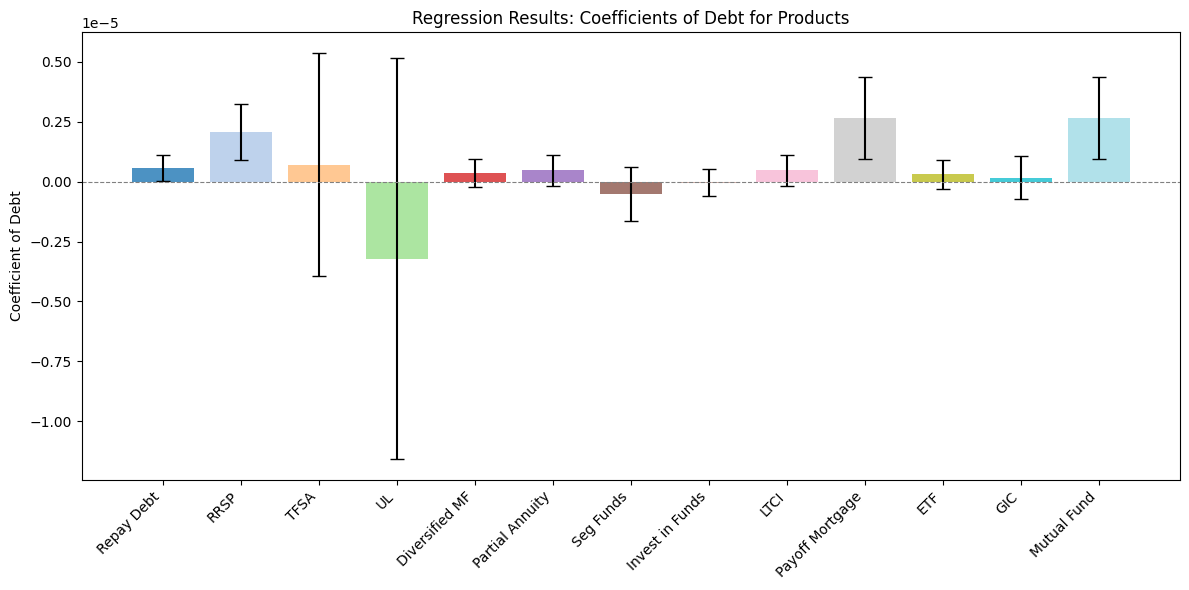

In [1]:
import matplotlib.pyplot as plt
import numpy as np


products = [
    "Repay Debt", "RRSP", "TFSA", "UL", "Diversified MF", "Partial Annuity",
    "Seg Funds", "Invest in Funds", "LTCI", "Payoff Mortgage", "ETF", "GIC", "Mutual Fund"
]
coefficients = [
    5.596e-07, 2.064e-06, 7.116e-07, -3.217e-06, 3.544e-07, 4.637e-07,
    -5.233e-07, -5.415e-08, 4.637e-07, 2.641e-06, 3.118e-07, 1.507e-07, 2.641e-06
]
std_errs = [
    2.79e-07, 5.87e-07, 2.38e-06, 4.27e-06, 3.05e-07, 3.29e-07,
    5.78e-07, 2.86e-07, 3.29e-07, 8.72e-07, 3.09e-07, 4.57e-07, 8.72e-07
]

conf_intervals = [1.96 * se for se in std_errs]


colors = plt.cm.tab20(np.linspace(0, 1, len(products)))

fig, ax = plt.subplots(figsize=(12, 6))
x_positions = np.arange(len(products))

ax.bar(x_positions, coefficients, yerr=conf_intervals, capsize=5, alpha=0.8, color=colors)

ax.set_xticks(x_positions)
ax.set_xticklabels(products, rotation=45, ha="right")
ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)  # 添加基线
ax.set_ylabel('Coefficient of Debt')
ax.set_title('Regression Results: Coefficients of Debt for Products')

plt.tight_layout()
plt.show()
